In [2]:
import pandas as pd
import numpy as np

## Package testing

In [5]:
from xtrader.dataloaders import ohlc
from xtrader.utils import select_columns

from xtrader.factors.returns import ReturnFactors
from xtrader.factors.momenta import MomentumFactors
from xtrader.factors.seasonal import SeasonalFactors
from xtrader.factors.technical import TechnicalFactors

prices = ohlc.load_prices('data/intraday/Bitcoin.csv', check_missing=False)

In [7]:
daily_returns = ReturnFactors.daily(prices['daily'], periods=[1, 2, 3], columns=['open', 'high'], normalize=True, dropna=True, return_full=False).head(6)

In [8]:
select_columns(daily_returns, 'open', drop_name=True)

,return_1d,return_2d,return_3d
date,,,
2017-08-20,0.007368,0.005439,-0.012699
2017-08-21,-0.030387,-0.011690,-0.006648
2017-08-22,-0.003950,-0.017257,-0.009117
2017-08-23,0.035614,0.015639,0.000059
2017-08-24,0.041995,0.038800,0.024350
2017-08-25,-0.005136,0.018157,0.023943


In [9]:
MomentumFactors.daily(prices['daily'], periods=[2, 3], columns='open', normalize=True, dropna=True, return_full=False).head(6)

,open_momentum_2d,open_momentum_3d
date,,
2017-08-20,-0.001929,-0.020067
2017-08-21,0.018697,0.023739
2017-08-22,-0.013307,-0.005166
2017-08-23,-0.019975,-0.035555
2017-08-24,-0.003196,-0.017646
2017-08-25,0.023293,0.029079


In [10]:
SeasonalFactors.time_indicators(prices['daily']).head()

,open,high,low,close,volume,symbol,name,day,day_of_week,week_of_year,month,quarter,year
date,,,,,,,,,,,,,
2017-08-17,4313.39,4337.38,4280.82,4285.08,81.645263,BTC,Bitcoin,17,3,33,8,3,2017
2017-08-18,4106.35,4136.48,4085.88,4108.37,44.936836,BTC,Bitcoin,18,4,33,8,3,2017
2017-08-19,4120.78,4139.98,4120.78,4139.98,0.052699,BTC,Bitcoin,19,5,33,8,3,2017
2017-08-20,4151.14,4171.62,4069.13,4086.29,69.475467,BTC,Bitcoin,20,6,33,8,3,2017
2017-08-21,4025.00,4031.87,3987.50,4016.00,10.963783,BTC,Bitcoin,21,0,34,8,3,2017


In [11]:
TechnicalFactors.bbands(prices['daily'], freq='d', columns=['open', 'high'], dropna=True, return_full=False).head(6)

,open_bbands_21d_2_2_up,open_bbands_21d_2_2_mid,open_bbands_21d_2_2_low,high_bbands_21d_2_2_up,high_bbands_21d_2_2_mid,high_bbands_21d_2_2_low
date,,,,,,
2017-09-06,4799.588458,4342.407143,3885.225828,4799.588458,4342.407143,3885.225828
2017-09-07,4841.470754,4361.765714,3882.060675,4841.470754,4361.765714,3882.060675
2017-09-08,4837.830736,4370.071905,3902.313073,4837.830736,4370.071905,3902.313073
2017-09-09,4835.016821,4375.730476,3916.444131,4835.016821,4375.730476,3916.444131
2017-09-10,4832.181846,4377.829524,3923.477202,4832.181846,4377.829524,3923.477202
2017-09-11,4818.997227,4386.994762,3954.992297,4818.997227,4386.994762,3954.992297


<Axes: xlabel='date'>

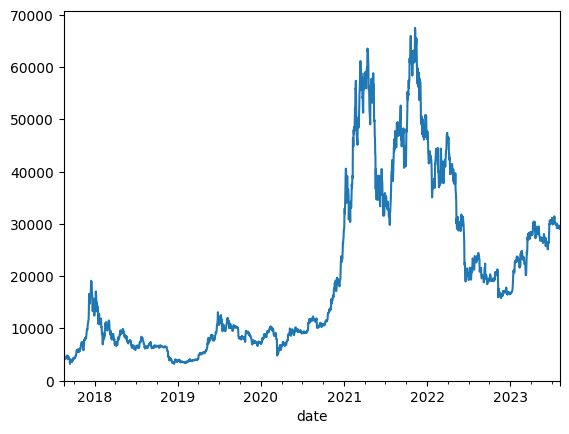

In [5]:
prices['daily'].close.plot()

In [7]:
from pykalman import KalmanFilter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

In [8]:
state_means, a = kf.filter(prices['daily'].close.values)

In [11]:
state_means = pd.Series(state_means.flatten(), index=prices['daily'].index)

<Axes: xlabel='date'>

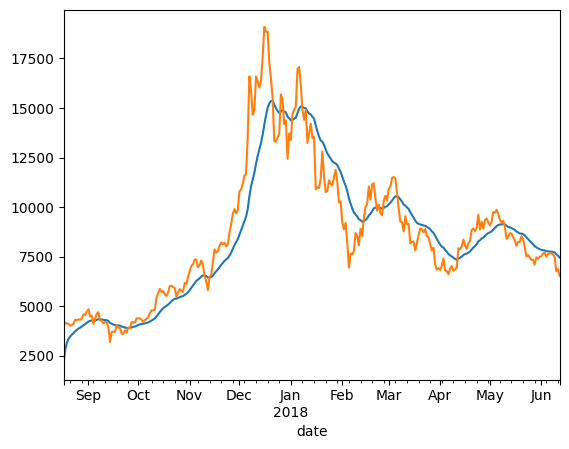

In [18]:
state_means.head(300).plot()
prices['daily'].head(300).close.plot()

In [1]:
import pywt

In [4]:
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

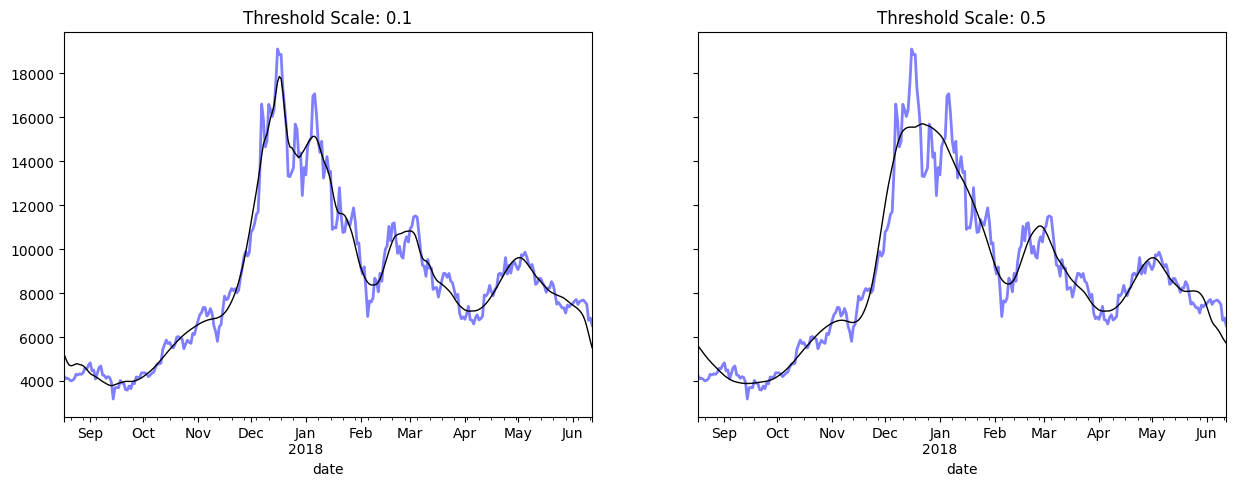

In [14]:
wavelet = "db6"
signal = prices['daily'].close.head(300)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

for i, scale in enumerate([.1, .5]):
    coefficients = pywt.wavedec(signal, wavelet, mode='per')
    coefficients[1:] = [pywt.threshold(i, value=scale*signal.max(), mode='soft') for i in coefficients[1:]]
    reconstructed_signal = pywt.waverec(coefficients, wavelet, mode='per')
    signal.plot(color="b", alpha=0.5, label='original signal', lw=2,
                 title=f'Threshold Scale: {scale:.1f}', ax=axes[i])
    pd.Series(reconstructed_signal, index=signal.index).plot(c='k', label='DWT smoothing}', linewidth=1, ax=axes[i])